**3.1 Linear Regression**

The dataset is called a **training dataset or training set**, and each row (containing the data corresponding to one sale) is called an **example (or data point, instance, sample)**. The thing we are trying to predict (price) is called a **label (or target)**. The variables (age and area) upon which the predictions are based are called **features (or covariates)**.

**Loss function**: quantify the distance between the real and predicted values of the target. The loss will usually be a nonnegative number where smaller values are better and perfect predictions incur a loss of 0. For regression problems, the most common loss function is the squared error. 

**Gradient descent**: an algorithm to iteratively reduce the error by updating the parameters in the direction that incrementally lowers the loss function.

**Prediction**: Given the model, we can now make predictions for a new example.

**3.1.2 Vectorization for Speed**

In [2]:
%matplotlib inline
import math
import time
import numpy as np
import torch
from d2l import torch as d2l

In [5]:
#we vectorize the calculations and leverage fast linear algebra libraries rather than writing costly for-loops in Python
n = 10000
a = torch.ones([n])
b = torch.ones([n])

In [4]:
class Timer:  #@save
    """记录多次运行时间"""
    def __init__(self):
        self.times = []
        self.start()

    def start(self):
        """启动计时器"""
        self.tik = time.time()

    def stop(self):
        """停止计时器并将时间记录在列表中"""
        self.times.append(time.time() - self.tik)
        return self.times[-1]

    def avg(self):
        """返回平均时间"""
        return sum(self.times) / len(self.times)

    def sum(self):
        """返回时间总和"""
        return sum(self.times)

    def cumsum(self):
        """返回累计时间"""
        return np.array(self.times).cumsum().tolist()

In [9]:
c = torch.zeros(n)
timer = Timer()
for i in range(n):
    c[i] = a[i] + b[i]
f'{timer.stop():.5f} sec'

'0.18876 sec'

In [12]:
timer.start()
d = a + b
f'{timer.stop():.5f} sec'

'0.00000 sec'

**3.1.3. The Normal Distribution and Squared Loss**

In [15]:
#define a normal distribution (Gaussian distribution)
def normal(x, mu, sigma):
    p = 1 / math.sqrt(2 * math.pi * sigma**2)
    return p * np.exp(-0.5 / sigma**2 * (x - mu)**2)

In [17]:
#creates an array that start with 7, stop at 7, and step with 0.01
x = np.arange(-7, 7, 0.01)
x

array([-7.  , -6.99, -6.98, ...,  6.97,  6.98,  6.99])

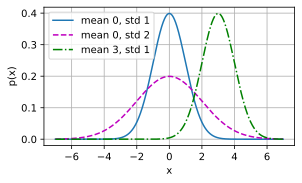

In [21]:
params = [(0, 1), (0, 2), (3, 1)]
d2l.plot(x, [normal(x, mu, sigma) for mu, sigma in params], xlabel='x',
         ylabel='p(x)', figsize=(4.5, 2.5),
         legend=[f'mean {mu}, std {sigma}' for mu, sigma in params])
#Note that changing the mean corresponds to a shift along the x-axis, and increasing the variance spreads the distribution out。
#linear regression with squared loss is to assume that observations arise from noisy measurements, where the noise follows the normal distribution

**3.1.4. Linear Regression as a Neural Network**

**Input layer (or feature dimensionality)**: x1, x2, ... , d  
**Output layer**: o1, o2  
**Fully-connected layer (or dense layer)**: all inputs have been connected with outputs directly.

**3.2 线性回归的从零开始实现**

In [51]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

In [40]:
#synthesis data
def synthetic_data(w, b, num_examples):
    X = torch.normal(0, 1, (num_examples, len(w)))  #torch.normal(mean, std, size(row, column))
    y = torch.matmul(X, w) + b  #torch.matmul(A, B): performs a matrix multiplication between A and B
    y += torch.normal(0, 0.01, y.shape)  #adds noise to the previously calculated y values.
    return X, y.reshape((-1, 1))  #reshape y size into [m,1]

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)

In [41]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.6319, 1.0589]) 
label: tensor([1.8665])


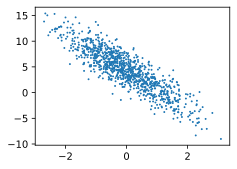

In [42]:
d2l.set_figsize()
d2l.plt.scatter(features[:, (1)].detach().numpy(), labels.detach().numpy(), 1);

**3.2.2. 读取数据集**

In [56]:
#定义一个data_iter函数， 该函数接收批量大小、特征矩阵和标签向量作为输入，生成大小为batch_size的小批量
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)  #shuffle a list (reorganize the order of the list items)
    for i in range (0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i:min(i + batch_size, num_examples)])
        yield features[batch_indices], labels[batch_indices]

In [57]:
#我们利用GPU并行运算的优势，处理合理大小的“小批量”。 每个样本都可以并行地进行模型计算，且每个样本损失函数的梯度也可以被并行计算。 
#GPU可以在处理几百个样本时，所花费的时间不比处理一个样本时多太多

#读取第一个小批量数据样本并打印
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

**3.2.3. 初始化模型参数**

In [64]:
#在我们开始用小批量随机梯度下降优化我们的模型参数之前， 我们需要先有一些参数 w, b
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
#在初始化参数之后，我们的任务是更新这些参数，直到这些参数足够拟合我们的数据。

**3.2.4. 定义模型**

In [65]:
def linreg(X, w, b):
    return torch.matmul(X, w) + b

**3.2.5. 定义损失函数**

In [66]:
def squared_loss(y_hat, y):
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2

**3.2.6. 定义优化算法**

In [68]:
#params: model parameters; lr: learning rate
def sgd(params, lr, batch_size):
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size  #This line updates each parameter by moving it in the direction that minimally reduces the loss (opposite the gradient)
            param.grad.zero_()  #This line resets the gradients of the parameter to zero after the parameter has been updated.

**3.2.7. 训练**

In [72]:
lr = 0.03
num_epochs = 3  #迭代周期
net = linreg
loss = squared_loss

for epoch in range(num_epochs):
    for X, y in data_iter(batch_size, features, labels):
        l = loss(net(X, w, b), y)  #
        l.sum().backward()  #计算关于[w,b]的梯度
        sgd([w, b], lr, batch_size)  # 使用参数的梯度更新参数
    with torch.no_grad():
        train_l = loss(net(features, w, b), labels)
        print(f'epoch {epoch + 1}, loss {float(train_l.mean()):f}')

epoch 1, loss 0.000051
epoch 2, loss 0.000051
epoch 3, loss 0.000051


In [74]:
print(f'w的估计误差: {true_w - w.reshape(true_w.shape)}')
print(f'b的估计误差: {true_b - b}')

w的估计误差: tensor([0.0010, 0.0006], grad_fn=<SubBackward0>)
b的估计误差: tensor([0.0009], grad_fn=<RsubBackward1>)


**小结**  
我们学习了深度网络是如何实现和优化的。在这一过程中只使用张量和自动微分，不需要定义层或复杂的优化器。  
这一节只触及到了表面知识。在下面的部分中，我们将基于刚刚介绍的概念描述其他模型，并学习如何更简洁地实现其他模型。

**3.3. 线性回归的简洁实现**

**3.3.1. 生成数据集**

In [21]:
import numpy as np
import torch
from torch.utils import data
from d2l import torch as d2l

true_w = torch.tensor([2, -3.4])
true_b = 4.2
features, labels = d2l.synthetic_data(true_w, true_b, 1000)

**3.3.2. 读取数据集**

In [22]:
def load_array(data_arrays, batch_size, is_train=True):
    dataset = data.TensorDataset(*data_arrays)
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

batch_size = 10
data_iter = load_array((features, labels), batch_size)

In [23]:
#使用iter构造Python迭代器，并使用next从迭代器中获取第一项
next(iter(data_iter))

[tensor([[ 0.5146, -1.4297],
         [ 0.3874,  0.4795],
         [-0.0858,  1.2093],
         [-0.2770, -1.1029],
         [-0.9491, -1.0212],
         [-0.0293,  0.8365],
         [-1.4519,  0.1539],
         [-0.3899, -0.8937],
         [ 0.9006, -1.5026],
         [ 1.4171,  0.9694]]),
 tensor([[10.1003],
         [ 3.3301],
         [-0.1058],
         [ 7.3892],
         [ 5.7730],
         [ 1.2942],
         [ 0.7694],
         [ 6.4539],
         [11.1064],
         [ 3.7468]])]

**3.3.3. 定义模型**

In [15]:
from torch import nn

#构建全连接层(fully-connected layer)
net = nn.Sequential(nn.Linear(2, 1))

**3.3.4. 初始化模型参数**

In [24]:
#通过net[0]选择网络中的第一个图层， 然后使用weight.data和bias.data方法访问参数
#还可以使用替换方法normal_和fill_来重写参数值
net[0].weight.data.normal_(0, 0.01)
net[0].bias.data.fill_(0)

tensor([0.])

**3.3.5. 损失函数**

In [25]:
#计算均方误差使用的是MSELoss类，也称为平方L2范数。 默认情况下，它返回所有样本损失的平均值。
loss = nn.MSELoss()

**3.3.6. 定义优化算法**

In [38]:
#小批量随机梯度下降算法是一种优化神经网络的标准工具， PyTorch在optim模块中实现了该算法的许多变种。
trainer = torch.optim.SGD(net.parameters(), lr=0.03)

**3.3.7. 训练**

In [40]:
num_epochs = 3
for epoch in range(num_epochs):
    for X, y in data_iter:
        l = loss(net(X) ,y)
        trainer.zero_grad()  #Zero the gradients before running the backward pass.
        l.backward()
        trainer.step()
    l = loss(net(features), labels)
    print(f'epoch {epoch + 1}, loss {l:f}')

epoch 1, loss 0.000091
epoch 2, loss 0.000092
epoch 3, loss 0.000091


In [45]:
w = net[0].weight.data
print(w)
print('w的估计误差：', true_w - w.reshape(true_w.shape))
b = net[0].bias.data
print(b)
print('b的估计误差：', true_b - b)

tensor([[ 1.9997, -3.3998]])
w的估计误差： tensor([ 0.0003, -0.0002])
tensor([4.1992])
b的估计误差： tensor([0.0008])


**小结**：
1. 我们可以使用PyTorch的高级API更简洁地实现模型。  
2. 在PyTorch中，data模块提供了数据处理工具，nn模块定义了大量的神经网络层和常见损失函数。  
3. 我们可以通过_结尾的方法将参数替换，从而初始化参数。

**3.4. softmax回归**

**独热编码（one-hot encoding）**: 独热编码是一个向量，它的分量和类别一样多。类别对应的分量设置为1，其他所有分量设置为0。 在我们的例子中，标签将是一个三维向量， 其中(1, 0, 0)对应于“猫”、(0, 1, 0)对应于“鸡”、(0, 0, 1)对应于“狗”。  
**softmax回归**: 是一个单层神经网络。由于计算每个输出o1、o2和o3取决于所有输入x1, x2, x3, x4, 所以softmax回归的输出层也是全连接层。softmax函数能够将未规范化的预测变换为非负数并且总和为1，同时让模型保持可导的性质。

**小结**：
1. softmax运算获取一个向量并将其映射为概率。  
2. softmax回归适用于分类问题，它使用了softmax运算中输出类别的概率分布。  
3. 交叉熵是一个衡量两个概率分布之间差异的很好的度量，它测量给定模型编码数据所需的比特数。

**3.5. 图像分类数据集**

In [1]:
%matplotlib inline
import torch
import torchvision
from torch.utils import data
from torchvision import transforms
from d2l import torch as d2l

d2l.use_svg_display()

In [2]:
#download the Fashion-MNIST database
# 通过ToTensor实例将图像数据从PIL类型变换成32位浮点数格式，
# 并除以255使得所有像素的数值均在0～1之间
trans = transforms.ToTensor()
mnist_train = torchvision.datasets.FashionMNIST(
    root="../data", train=True, transform=trans, download=True)
mnist_test = torchvision.datasets.FashionMNIST(
    root="../data", train=False, transform=trans, download=True)

In [3]:
len(mnist_train), len(mnist_test)

(60000, 10000)

In [4]:
mnist_train[0][0].shape

torch.Size([1, 28, 28])

In [5]:
def get_fashion_mnist_labels(labels):  #@save
    """返回Fashion-MNIST数据集的文本标签"""
    text_labels = ['t-shirt', 'trouser', 'pullover', 'dress', 'coat',
                   'sandal', 'shirt', 'sneaker', 'bag', 'ankle boot']
    return [text_labels[int(i)] for i in labels]

In [6]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):  #@save
    """绘制图像列表"""
    figsize = (num_cols * scale, num_rows * scale)
    _, axes = d2l.plt.subplots(num_rows, num_cols, figsize=figsize)
    axes = axes.flatten()
    for i, (ax, img) in enumerate(zip(axes, imgs)):
        if torch.is_tensor(img):
            # 图片张量
            ax.imshow(img.numpy())
        else:
            # PIL图片
            ax.imshow(img)
        ax.axes.get_xaxis().set_visible(False)
        ax.axes.get_yaxis().set_visible(False)
        if titles:
            ax.set_title(titles[i])
    return axes

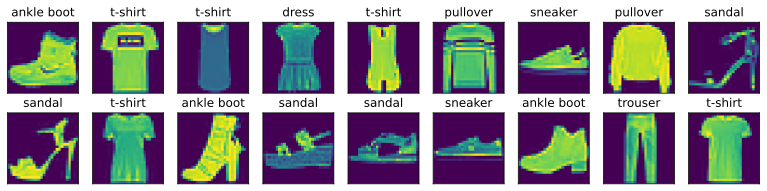

In [7]:
X, y = next(iter(data.DataLoader(mnist_train, batch_size=18)))
show_images(X.reshape(18, 28, 28), 2, 9, titles=get_fashion_mnist_labels(y));

**3.5.2. 读取小批量**

In [8]:
batch_size = 256

def get_dataloader_workers():
    """使用4个进程来读取数据"""
    return 4

#通过内置数据迭代器，我们可以随机打乱了所有样本，从而无偏见地读取小批量
train_iter = data.DataLoader(mnist_train, batch_size, shuffle=True,
                             num_workers=get_dataloader_workers())

In [9]:
timer = d2l.Timer()
for X, y in train_iter:
    continue
f'{timer.stop():.2f} sec'

'4.94 sec'

In [10]:
#定义load_data_fashion_mnist函数，用于获取和读取Fashion-MNIST数据集
def load_data_fashion_mnist(batch_size, resize=None):  #@save
    """下载Fashion-MNIST数据集，然后将其加载到内存中"""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(
        root="../data", train=True, transform=trans, download=True)
    mnist_test = torchvision.datasets.FashionMNIST(
        root="../data", train=False, transform=trans, download=True)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True,
                            num_workers=get_dataloader_workers()),
            data.DataLoader(mnist_test, batch_size, shuffle=False,
                            num_workers=get_dataloader_workers()))

In [11]:
#指定resize参数来测试load_data_fashion_mnist函数的图像大小调整功能
train_iter, test_iter = load_data_fashion_mnist(32, resize=64)
for X, y in train_iter:
    print(X.shape, X.dtype, y.shape, y.dtype)
    break

torch.Size([32, 1, 64, 64]) torch.float32 torch.Size([32]) torch.int64


**小结**：  
1. Fashion-MNIST是一个服装分类数据集，由10个类别的图像组成。我们将在后续章节中使用此数据集来评估各种分类算法。
2. 我们将高度h像素，宽度w像素图像的形状记为h*w或（h,w)。
3. 数据迭代器是获得更高性能的关键组件。依靠实现良好的数据迭代器，利用高性能计算来避免减慢训练过程。

**3.6. softmax回归的从零开始实现**

In [12]:
import torch
from IPython import display
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

In [13]:
#sample size: 28 x 28; output: 10 categories; weights: 784 x 10 matrix
num_inputs = 784
num_outputs = 10

#使用正态分布初始化我们的权重W，偏置初始化为0
W = torch.normal(0, 0.01, size=(num_inputs, num_outputs),requires_grad=True)
b = torch.zeros(num_outputs, requires_grad=True)

**3.6.2 定义softmax操作**

In [14]:
#sum: 对同一个轴上的元素，即同一列（轴0）或同一行（轴1）求和
X = torch.tensor([[1.0, 2.0, 3.0], [4.0, 5.0, 6.0]])
X.sum(0, keepdim=True), X.sum(1, keepdim=True)

(tensor([[5., 7., 9.]]),
 tensor([[ 6.],
         [15.]]))

**实现softmax由三个步骤组成**:  
1. 对每个项求幂（使用exp);  
2. 对每一行求和（小批量中每个样本是一行），得到每个样本的规范化常数；  
3. 将每一行除以其规范化常数，确保结果的和为1.

In [15]:
#分母或规范化常数，有时也称为配分函数（其对数称为对数-配分函数）
#构建softmax函数
def softmax(X):
    X_exp = torch.exp(X)
    partition = X_exp.sum(1, keepdim=True)
    return X_exp / partition  # 这里应用了广播机制

In [19]:
X = torch.normal(0, 1, (2, 5))  #create a 2 x 5 matrix with a mean of 0 and std of 1.
X_prob = softmax(X)
X, X_prob, X_prob.sum(1)

(tensor([[-1.2098,  0.5592, -0.2242,  1.0495, -1.3224],
         [-0.1043,  0.4813,  0.0367, -0.4500,  0.4420]]),
 tensor([[0.0500, 0.2930, 0.1339, 0.4785, 0.0446],
         [0.1567, 0.2814, 0.1804, 0.1109, 0.2706]]),
 tensor([1., 1.]))

注意，虽然这在数学上看起来是正确的，但我们在代码实现中有点草率。 矩阵中的非常大或非常小的元素可能造成数值上溢或下溢，但我们没有采取措施来防止这点。

**3.6.3 定义模型**

In [21]:
#定义输入如何通过网络映射到输出 (simple neural network layer)
def net(X):
    return softmax(torch.matmul(X.reshape((-1, W.shape[0])), W) + b)

**3.6.4 定义损失函数**

In [23]:
y = torch.tensor([0, 2])
y_hat = torch.tensor([[0.1, 0.3, 0.6],[0.3, 0.2, 0.5]])  #第一个样本的预测类别是2（该行的最大元素为0.6，索引为2），这与实际标签0不一致。 第二个样本的预测类别是2（该行的最大元素为0.5，索引为2），这与实际标签2一致。
y_hat[[0, 1], y]

tensor([0.1000, 0.5000])

In [25]:
#定义交叉熵损失函数 (cross-entropy loss function), commonly used in classification tasks. 
def cross_entropy(y_hat, y):
    return - torch.log(y_hat[range(len(y_hat)), y])

cross_entropy(y_hat, y)

tensor([2.3026, 0.6931])

**3.6.5 分类精度**

In [26]:
def accuracy(y_hat, y):  #@save
    """计算预测正确的数量"""
    if len(y_hat.shape) > 1 and y_hat.shape[1] > 1:
        y_hat = y_hat.argmax(axis=1)
    cmp = y_hat.type(y.dtype) == y
    return float(cmp.type(y.dtype).sum())

In [27]:
accuracy(y_hat, y) / len(y)

0.5

In [28]:
def evaluate_accuracy(net, data_iter):  #@save
    """计算在指定数据集上模型的精度"""
    if isinstance(net, torch.nn.Module):
        net.eval()  # 将模型设置为评估模式
    metric = Accumulator(2)  # 正确预测数、预测总数
    with torch.no_grad():
        for X, y in data_iter:
            metric.add(accuracy(net(X), y), y.numel())
    return metric[0] / metric[1]

In [29]:
class Accumulator:  #@save
    """在n个变量上累加"""
    def __init__(self, n):
        self.data = [0.0] * n

    def add(self, *args):
        self.data = [a + float(b) for a, b in zip(self.data, args)]

    def reset(self):
        self.data = [0.0] * len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [30]:
evaluate_accuracy(net, test_iter)

0.0397

**3.6.6 训练**

In [32]:
def train_epoch_ch3(net, train_iter, loss, updater):  #@save
    """训练模型一个迭代周期（定义见第3章）"""
    # 将模型设置为训练模式
    if isinstance(net, torch.nn.Module):
        net.train()
    # 训练损失总和、训练准确度总和、样本数
    metric = Accumulator(3)
    for X, y in train_iter:
        # 计算梯度并更新参数
        y_hat = net(X)
        l = loss(y_hat, y)
        if isinstance(updater, torch.optim.Optimizer):
            # 使用PyTorch内置的优化器和损失函数
            updater.zero_grad()
            l.mean().backward()
            updater.step()
        else:
            # 使用定制的优化器和损失函数
            l.sum().backward()
            updater(X.shape[0])
        metric.add(float(l.sum()), accuracy(y_hat, y), y.numel())
    # 返回训练损失和训练精度
    return metric[0] / metric[2], metric[1] / metric[2]

In [33]:
class Animator:  #@save
    """在动画中绘制数据"""
    def __init__(self, xlabel=None, ylabel=None, legend=None, xlim=None,
                 ylim=None, xscale='linear', yscale='linear',
                 fmts=('-', 'm--', 'g-.', 'r:'), nrows=1, ncols=1,
                 figsize=(3.5, 2.5)):
        # 增量地绘制多条线
        if legend is None:
            legend = []
        d2l.use_svg_display()
        self.fig, self.axes = d2l.plt.subplots(nrows, ncols, figsize=figsize)
        if nrows * ncols == 1:
            self.axes = [self.axes, ]
        # 使用lambda函数捕获参数
        self.config_axes = lambda: d2l.set_axes(
            self.axes[0], xlabel, ylabel, xlim, ylim, xscale, yscale, legend)
        self.X, self.Y, self.fmts = None, None, fmts

    def add(self, x, y):
        # 向图表中添加多个数据点
        if not hasattr(y, "__len__"):
            y = [y]
        n = len(y)
        if not hasattr(x, "__len__"):
            x = [x] * n
        if not self.X:
            self.X = [[] for _ in range(n)]
        if not self.Y:
            self.Y = [[] for _ in range(n)]
        for i, (a, b) in enumerate(zip(x, y)):
            if a is not None and b is not None:
                self.X[i].append(a)
                self.Y[i].append(b)
        self.axes[0].cla()
        for x, y, fmt in zip(self.X, self.Y, self.fmts):
            self.axes[0].plot(x, y, fmt)
        self.config_axes()
        display.display(self.fig)
        display.clear_output(wait=True)

In [34]:
def train_ch3(net, train_iter, test_iter, loss, num_epochs, updater):  #@save
    """训练模型（定义见第3章）"""
    animator = Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0.3, 0.9],
                        legend=['train loss', 'train acc', 'test acc'])
    for epoch in range(num_epochs):
        train_metrics = train_epoch_ch3(net, train_iter, loss, updater)
        test_acc = evaluate_accuracy(net, test_iter)
        animator.add(epoch + 1, train_metrics + (test_acc,))
    train_loss, train_acc = train_metrics
    assert train_loss < 0.5, train_loss
    assert train_acc <= 1 and train_acc > 0.7, train_acc
    assert test_acc <= 1 and test_acc > 0.7, test_acc

In [35]:
lr = 0.1

def updater(batch_size):
    return d2l.sgd([W, b], lr, batch_size)

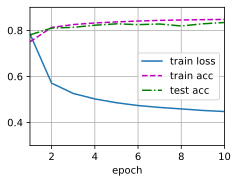

In [36]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, cross_entropy, num_epochs, updater)

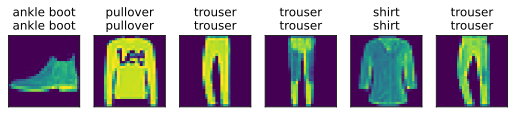

In [37]:
def predict_ch3(net, test_iter, n=6):  #@save
    """预测标签（定义见第3章）"""
    for X, y in test_iter:
        break
    trues = d2l.get_fashion_mnist_labels(y)
    preds = d2l.get_fashion_mnist_labels(net(X).argmax(axis=1))
    titles = [true +'\n' + pred for true, pred in zip(trues, preds)]
    d2l.show_images(
        X[0:n].reshape((n, 28, 28)), 1, n, titles=titles[0:n])

predict_ch3(net, test_iter)

**3.6.8 小结**  
1. 借助softmax回归，我们可以训练多分类的模型。  
2. 训练softmax回归循环模型与训练线性回归模型非常相似：先读取数据，再定义模型和损失函数，然后使用优化算法训练模型。大多数常见的深度学习模型都有类似的训练过程。

**3.7 softmax回归的简洁实现** 

In [39]:
import torch
from torch import nn
from d2l import torch as d2l

batch_size = 256
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)

**3.7.1 softmax回归的简洁实现** 

In [40]:
# PyTorch不会隐式地调整输入的形状。因此，
# 我们在线性层前定义了展平层（flatten），来调整网络输入的形状
net = nn.Sequential(nn.Flatten(), nn.Linear(784, 10))  #maps the flattened input from 784 features to 10 output features. 

def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=0.01)

net.apply(init_weights);

In [42]:
#在交叉熵损失函数中传递未规范化的预测，并同时计算softmax及其对数
loss = nn.CrossEntropyLoss(reduction='none')

**3.7.2 优化算法** 

In [44]:
trainer = torch.optim.SGD(net.parameters(), lr=0.1)

**3.7.3 训练**

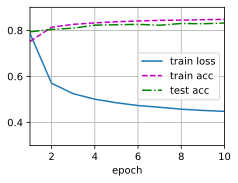

In [49]:
num_epochs = 10
train_ch3(net, train_iter, test_iter, loss, num_epochs, trainer)

**3.7.5. 小结**
1. 使用深度学习框架的高级API，我们可以更简洁地实现softmax回归。
2. 从计算的角度来看，实现softmax回归比较复杂。在许多情况下，深度学习框架在这些著名的技巧之外采取了额外的预防措施，来确保数值的稳定性。这使我们避免了在实践中从零开始编写模型时可能遇到的陷阱。